# Applying Data Science Model Development (XGboost)

## 1. Preprocess the data

In [15]:
# Install Optuna package ready for hyperparameter tuning
pip install optuna

SyntaxError: invalid syntax (2971386439.py, line 2)

In [16]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

In [17]:
# === Step 1: Data Preparation ===
# Load the data (train, validate, and test)
df = pd.read_csv("Final_v2_processed.csv") 
test_df = pd.read_csv("Final_test_v2_processed.csv")

# List of columns to be removed
columns_to_remove = ["recoveries", "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag"]

# Remove the specified column
df = df.drop(columns=columns_to_remove, errors='ignore')  
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')

# Need to handle the state variable - convert state names to numbers
# The LabelEncoder transforms categorical data into numerical values
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"]) 
test_df["addr_state"] = le.fit_transform(test_df["addr_state"])

# Define our features and target variable
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Converting to numpy arrays for faster processing
X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# No need to reshape for XGBoost because it works with 2D data: [n_samples, n_features]

# Creating XGBoost's specialized data structure - DMatrix
# This format is optimized for the XGBoost algorithm and improves performance
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

## 2. Hyperparameter Tuning

In [18]:
# === Step 2: Optuna Hyperparameter Tuning ===
def objective(trial):
    # Define the hyperparameters to search through to find the best configuration for our data
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), # Tree type to use
        'max_depth': trial.suggest_int('max_depth', 3, 10), # How deep should trees be?
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Number of trees to build
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Fraction of samples used for fitting trees
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Fraction of features used per tree
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 regularisation
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularisation
    }
    
    # Storage for evaluation results
    evals_result = {}
    
    # Train a model with the current trial's parameters
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100, # Max number of trees
        evals=[(dval, 'validation')], # Dataset to evaluate on
        early_stopping_rounds=10, # Stop if no improvement after 10 rounds
        evals_result=evals_result,
        verbose_eval=False # Don't print evaluation results for each iteration
    )
    
    # Get best score
    preds = model.predict(dval)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in preds]
    f1 = f1_score(y_val, y_pred_binary, average="weighted")
    
    return 1 - f1  # Optuna minimizes, so we use 1 - F1

# Run Optuna
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-28 17:05:06,740] A new study created in memory with name: no-name-c85f3900-96ba-44e3-aba1-11389aea5776
[I 2025-04-28 17:05:08,751] Trial 0 finished with value: 0.2365000558912581 and parameters: {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.04095294311306582, 'n_estimators': 393, 'min_child_weight': 2, 'gamma': 0.01961570172190023, 'subsample': 0.7939761716203353, 'colsample_bytree': 0.5038275966149143, 'reg_alpha': 0.0005804803986447646, 'reg_lambda': 0.0024964729060371928}. Best is trial 0 with value: 0.2365000558912581.
[I 2025-04-28 17:05:29,659] Trial 1 finished with value: 0.23665758009009585 and parameters: {'booster': 'dart', 'max_depth': 8, 'learning_rate': 0.03381446680577404, 'n_estimators': 252, 'min_child_weight': 7, 'gamma': 0.026588525950605728, 'subsample': 0.5680306261741364, 'colsample_bytree': 0.9745445010744899, 'reg_alpha': 0.031151163759217126, 'reg_lambda': 1.5110348332793782e-08}. Best is trial 0 with value: 0.2365000558912581.
[I 2025-04-2

Best hyperparameters: {'booster': 'dart', 'max_depth': 10, 'learning_rate': 0.2623788419445012, 'n_estimators': 366, 'min_child_weight': 4, 'gamma': 4.818490064877905e-06, 'subsample': 0.7010825563369756, 'colsample_bytree': 0.6597327568863054, 'reg_alpha': 1.1994005457695826e-08, 'reg_lambda': 0.7040892564603983}


## 3. Re-learn with the optimized parameters

In [19]:
# === Step 3: Train Final Model with Best Params ===
# Extract parameters from best trial
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': best_params['booster'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'min_child_weight': best_params['min_child_weight'],
    'gamma': best_params['gamma'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
}

# Initialise lists to track model performance during training
evals_result = {}

# Train the final model with the best parameters we found
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# Save the model
joblib.dump(final_model, "xgboost_credit_default_model.pkl")


[0]	train-auc:0.71404	validation-auc:0.67473
[1]	train-auc:0.74443	validation-auc:0.68759
[2]	train-auc:0.75971	validation-auc:0.69180
[3]	train-auc:0.77126	validation-auc:0.69848
[4]	train-auc:0.78219	validation-auc:0.70327
[5]	train-auc:0.79046	validation-auc:0.70545
[6]	train-auc:0.79755	validation-auc:0.70662
[7]	train-auc:0.80527	validation-auc:0.70673
[8]	train-auc:0.81018	validation-auc:0.70864
[9]	train-auc:0.81325	validation-auc:0.70916
[10]	train-auc:0.81840	validation-auc:0.71092
[11]	train-auc:0.82346	validation-auc:0.71186
[12]	train-auc:0.82768	validation-auc:0.71327
[13]	train-auc:0.83075	validation-auc:0.71381
[14]	train-auc:0.83497	validation-auc:0.71445
[15]	train-auc:0.83829	validation-auc:0.71538
[16]	train-auc:0.84016	validation-auc:0.71617
[17]	train-auc:0.84473	validation-auc:0.71709
[18]	train-auc:0.84806	validation-auc:0.71756
[19]	train-auc:0.85120	validation-auc:0.71752
[20]	train-auc:0.85482	validation-auc:0.71820
[21]	train-auc:0.85695	validation-auc:0.7185

['xgboost_credit_default_model.pkl']

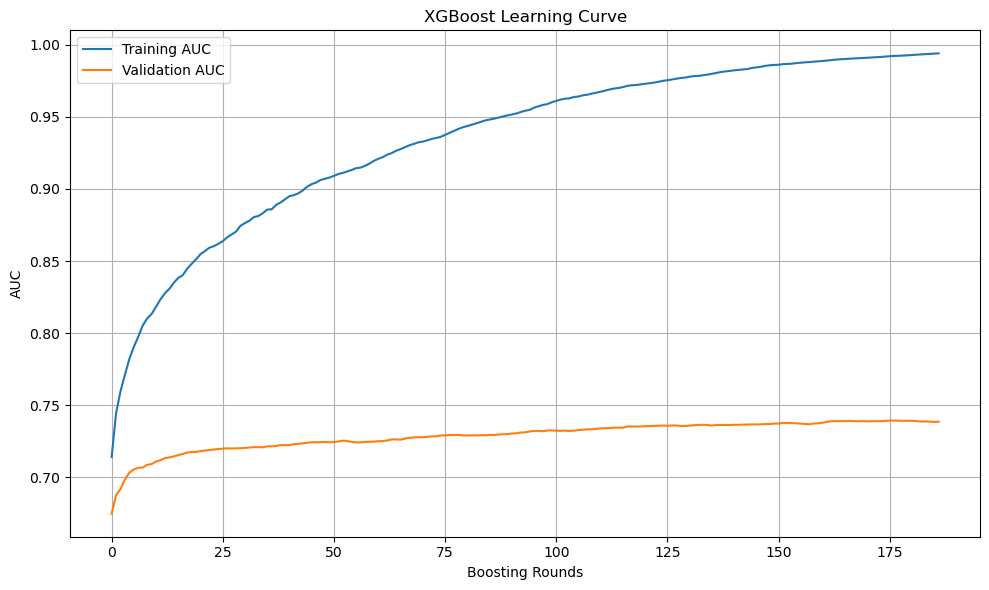

In [20]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['auc'], label='Training AUC')
plt.plot(evals_result['validation']['auc'], label='Validation AUC')
plt.title('XGBoost Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# === Step 4: Generate Prediction Results ===
# Get predictions on validation data
val_probs = final_model.predict(dval)
val_preds = [1 if prob > 0.5 else 0 for prob in val_probs]

# Store results in a DataFrame 
results_df_xg = pd.DataFrame({
    "true_label": y_val,
    "predicted_label": val_preds,
    "probability_0": 1 - val_probs,  # Probability for class 0
    "probability_1": val_probs       # Probability for class 1
})

# Save and preview results
results_df_xg.to_csv("xgboost_results.csv")
results_df_xg

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.884149,0.115851
1,0,0,0.958365,0.041635
2,0,0,0.768274,0.231726
3,0,0,0.777665,0.222335
4,0,0,0.701726,0.298274
...,...,...,...,...
34851,1,0,0.754696,0.245304
34852,0,0,0.963716,0.036284
34853,0,0,0.696915,0.303085
34854,0,0,0.982121,0.017879


## 4. Evaluate the Model

In [32]:
def comprehensive_evaluate(model, X, y, dataset_name="", threshold=0.5):
    """
    Comprehensive evaluation function for credit scoring models that calculates all required metrics
    
    Parameters:
    -----------
    model : XGBoost model
        The trained model
    X : array-like
        Feature data
    y : array-like
        True labels (0 for non-default, 1 for default)
    dataset_name : str
        Name of the dataset being evaluated
    threshold : float
        Classification threshold for converting probabilities to binary predictions
        
    Returns:
    --------
    metrics_dict : dict
        Dictionary with all evaluation metrics
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        roc_auc_score, f1_score, precision_score, recall_score, 
        confusion_matrix, accuracy_score, roc_curve
    )
    import xgboost as xgb
    
    # Create DMatrix for prediction
    dmatrix = xgb.DMatrix(X)
    y_prob = model.predict(dmatrix)
    
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_prob > threshold).astype(int)
    
    # Confusion matrix elements
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate all required metrics
    # 1. AUC-ROC
    auc_roc = roc_auc_score(y, y_prob)
    
    # 2. F1-Score (unweighted binary version as required)
    f1 = f1_score(y, y_pred, average='binary')
    
    # 3. Precision
    precision = precision_score(y, y_pred)
    
    # 4. Recall (Sensitivity or TPR)
    recall = recall_score(y, y_pred)
    
    # 5. Accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # 6. Specificity (TNR)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # 7. G-means (geometric mean of sensitivity and specificity)
    # Primarily used for threshold selection as noted
    g_mean = np.sqrt(recall * specificity)
    
    # Store all metrics in a dictionary
    metrics_dict = {
        'Dataset': dataset_name,
        'Threshold': threshold,
        'AUC-ROC': auc_roc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'Specificity': specificity,
        'G-mean': g_mean,
        'Confusion Matrix': cm
    }
    
    # Print results in a well-formatted way
    print(f"\n=== Evaluation on {dataset_name} (threshold: {threshold}) ===")
    print(f"AUC-ROC:     {auc_roc:.4f}")
    print(f"F1-Score:    {f1:.4f}  (unweighted binary version)")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"G-mean:      {g_mean:.4f}  (for threshold selection)")
    print("\nConfusion Matrix:")
    print(cm)
    print(f"[[TN={tn} FP={fp}]")
    print(f" [FN={fn} TP={tp}]]")
    
    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name} (threshold: {threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return metrics_dict

def find_optimal_thresholds(model, X, y):
    """
    Find optimal thresholds based on different metrics
    
    Parameters:
    -----------
    model : XGBoost model
        The trained model
    X : array-like
        Feature data
    y : array-like
        True labels
        
    Returns:
    --------
    thresholds_dict : dict
        Dictionary with optimal thresholds
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve, roc_curve
    import xgboost as xgb
    
    # Create DMatrix and get predictions
    dmatrix = xgb.DMatrix(X)
    y_prob = model.predict(dmatrix)
    
    # Find optimal threshold based on F1 score
    precisions, recalls, pr_thresholds = precision_recall_curve(y, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    f1_scores = f1_scores[:-1]  # Align with thresholds array length
    f1_optimal_idx = np.argmax(f1_scores)
    f1_optimal_threshold = pr_thresholds[f1_optimal_idx]
    
    # Find optimal threshold based on G-mean
    # First calculate all possible G-means for different thresholds
    g_means = []
    possible_thresholds = np.linspace(0.01, 0.99, 99)
    
    for threshold in possible_thresholds:
        y_pred = (y_prob > threshold).astype(int)
        # Calculate confusion matrix
        tn = np.sum((y == 0) & (y_pred == 0))
        fp = np.sum((y == 0) & (y_pred == 1))
        fn = np.sum((y == 1) & (y_pred == 0))
        tp = np.sum((y == 1) & (y_pred == 1))
        
        # Calculate sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate G-mean
        g_mean = np.sqrt(sensitivity * specificity)
        g_means.append(g_mean)
    
    # Find the threshold that maximizes G-mean
    g_mean_optimal_idx = np.argmax(g_means)
    g_mean_optimal_threshold = possible_thresholds[g_mean_optimal_idx]
    
    # Store thresholds
    thresholds_dict = {
        'F1 Optimal': f1_optimal_threshold,
        'G-mean Optimal': g_mean_optimal_threshold,
        'Standard': 0.5
    }
    
    # Plot threshold impacts
    plt.figure(figsize=(10, 6))
    plt.plot(pr_thresholds, f1_scores, label='F1 Score')
    plt.plot(possible_thresholds, g_means, label='G-mean')
    plt.axvline(x=f1_optimal_threshold, color='r', linestyle='--', 
                label=f'F1 Optimal ({f1_optimal_threshold:.3f})')
    plt.axvline(x=g_mean_optimal_threshold, color='g', linestyle='--', 
                label=f'G-mean Optimal ({g_mean_optimal_threshold:.3f})')
    plt.axvline(x=0.5, color='k', linestyle=':', label='Standard (0.5)')
    plt.title('Impact of Threshold on F1-Score and G-mean')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\n=== Optimal Thresholds ===")
    print(f"F1 Optimal:      {f1_optimal_threshold:.3f}")
    print(f"G-mean Optimal:  {g_mean_optimal_threshold:.3f}")
    print(f"Standard:        {0.5:.3f}")
    print("\nNote: F1-score serves both for threshold selection and model performance evaluation.")
    print("      G-mean is primarily used for threshold selection in imbalanced datasets.")
    
    return thresholds_dict

# Example usage:
# 1. Find optimal thresholds
# thresholds = find_optimal_thresholds(final_model, X_val, y_val)
#
# 2. Evaluate with different thresholds
# standard_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data", 0.5)
# f1_optimal_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data", thresholds['F1 Optimal'])
# gmean_optimal_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data", thresholds['G-mean Optimal'])

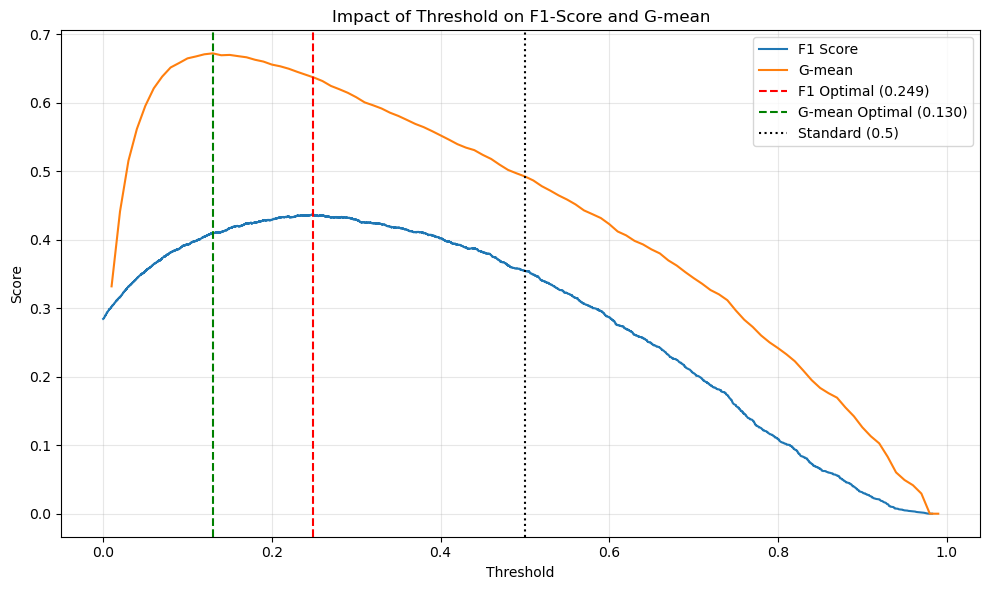


=== Optimal Thresholds ===
F1 Optimal:      0.249
G-mean Optimal:  0.130
Standard:        0.500

Note: F1-score serves both for threshold selection and model performance evaluation.
      G-mean is primarily used for threshold selection in imbalanced datasets.

=== Evaluation on Test Data (threshold: 0.5) ===
AUC-ROC:     0.6232
F1-Score:    0.1516  (unweighted binary version)
Precision:   0.1800
Recall:      0.1309
Accuracy:    0.8621
Specificity: 0.9381
G-mean:      0.3504  (for threshold selection)

Confusion Matrix:
[[110000   7261]
 [ 10583   1594]]
[[TN=110000 FP=7261]
 [FN=10583 TP=1594]]


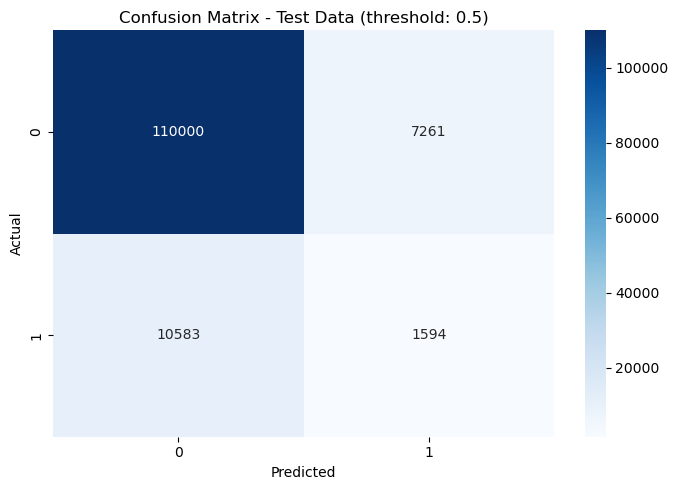

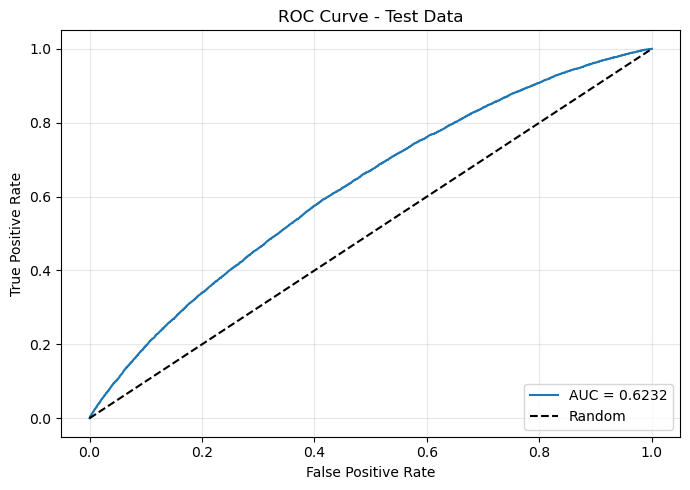


=== Evaluation on Test Data (F1 optimal) (threshold: 0.24890652298927307) ===
AUC-ROC:     0.6232
F1-Score:    0.2076  (unweighted binary version)
Precision:   0.1489
Recall:      0.3426
Accuracy:    0.7539
Specificity: 0.7967
G-mean:      0.5224  (for threshold selection)

Confusion Matrix:
[[93416 23845]
 [ 8005  4172]]
[[TN=93416 FP=23845]
 [FN=8005 TP=4172]]


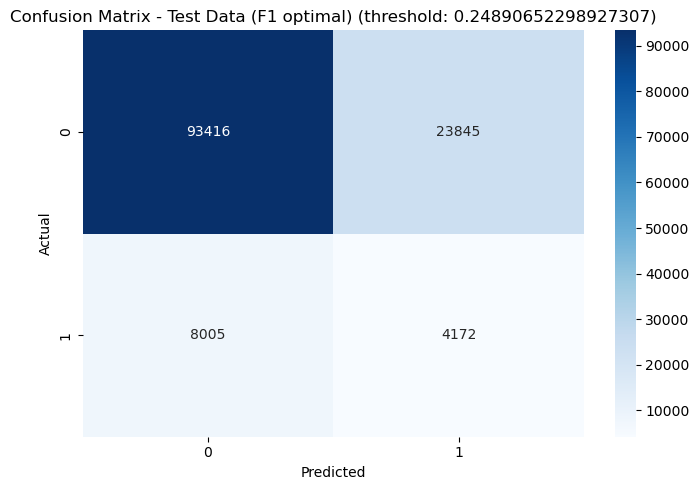

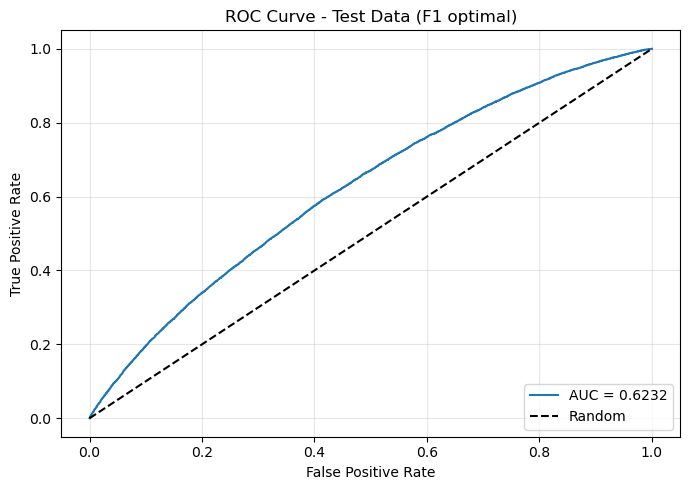


=== Evaluation on Test Data (G-mean optimal) (threshold: 0.13) ===
AUC-ROC:     0.6232
F1-Score:    0.2114  (unweighted binary version)
Precision:   0.1311
Recall:      0.5457
Accuracy:    0.6171
Specificity: 0.6245
G-mean:      0.5838  (for threshold selection)

Confusion Matrix:
[[73228 44033]
 [ 5532  6645]]
[[TN=73228 FP=44033]
 [FN=5532 TP=6645]]


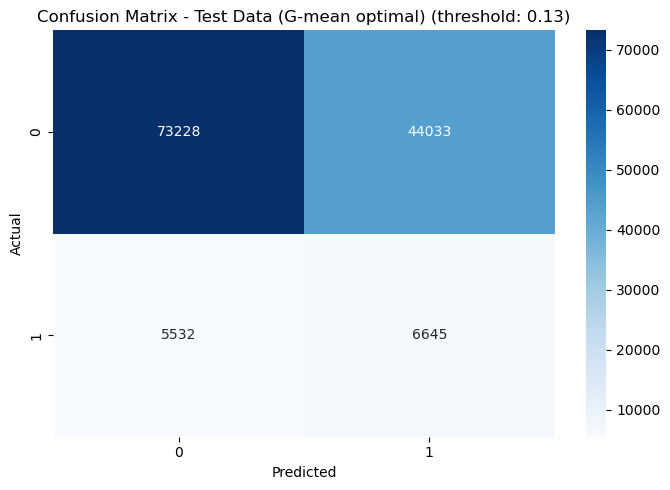

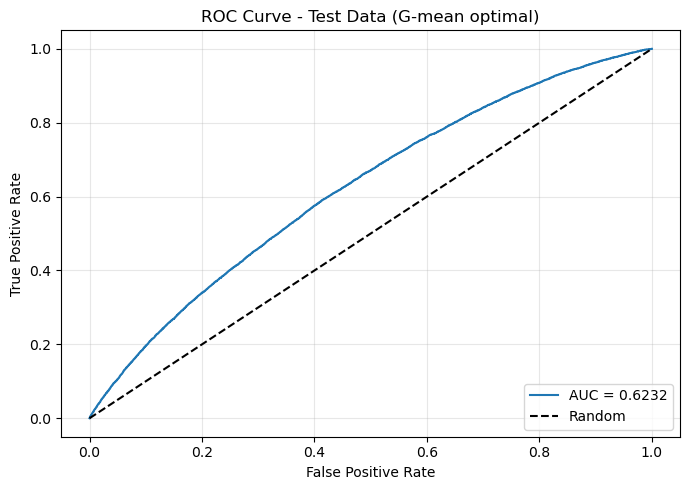

In [33]:
# Find optimal thresholds based on both F1 and G-mean
thresholds = find_optimal_thresholds(final_model, X_val, y_val)

# Evaluate with standard threshold
standard_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data", 0.5)

# Evaluate with optimal thresholds
f1_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data (F1 optimal)", thresholds['F1 Optimal'])
gmean_metrics = comprehensive_evaluate(final_model, X_test, y_test, "Test Data (G-mean optimal)", thresholds['G-mean Optimal'])

<Figure size 1200x800 with 0 Axes>

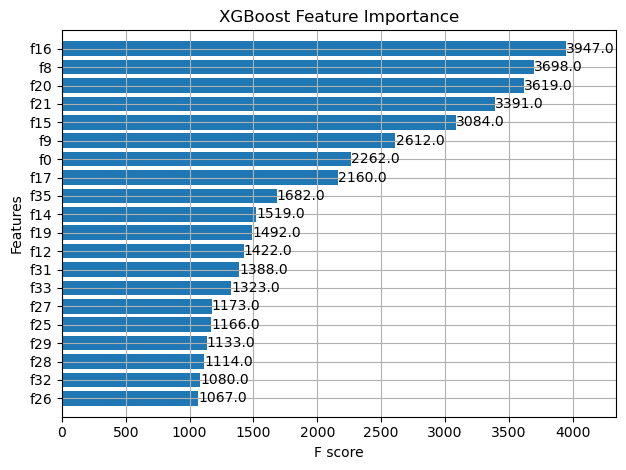


Top 10 Most Important Features:
  Feature  Importance
0      f1   14.182088
1      f2   10.453769
2     f12    4.293652
3      f7    4.084031
4      f3    4.073656
5     f24    4.066091
6     f17    4.027507
7     f15    3.953197
8     f26    3.873304
9     f32    3.831198


In [23]:
# === Step 6: Feature Importance Analysis ===
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Get feature names and importance values
feature_importance = final_model.get_score(importance_type='gain')

# Create a list of tuples with feature names and importance scores
feature_tuples = [(k, v) for k, v in feature_importance.items()]

# Sort by importance
sorted_features = sorted(feature_tuples, key=lambda x: x[1], reverse=True)

# Convert to dataframe for better display
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Print top 10 important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))